# Nested rejection sampling

This example demonstrates how to use nested rejection sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data.

[1] "Nested Sampling for General Bayesian Computation", John Skilling, Bayesian Analysis (2006) [https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944](https://projecteuclid.org/download/pdf_1/euclid.ba/1340370944).

First create fake data.

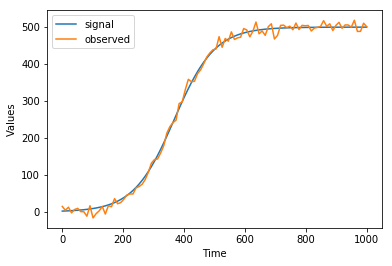

In [1]:
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma * 0.5],
    [0.02, 600, sigma * 1.5])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.NestedController(log_likelihood, log_prior, method=pints.NestedRejectionSampler)

# Set number of iterations
sampler.set_iterations(3000)

# Set the number of posterior samples to generate
sampler.set_n_posterior_samples(300)

# Set parallel
sampler.set_parallel(True)

Run the sampler!

In [3]:
samples = sampler.run()
print('Done!')

Running Nested rejection sampler
Number of active points: 400
Total number of iterations: 3000
Total number of posterior samples: 300
Iter. Eval. Time m:s Delta_log(z) Acceptance rate
0     1       0:02.2 -inf          1             
0     2       0:02.2 -inf          1             
0     3       0:02.3 -inf          1             
0     4       0:02.3 -inf          1             
0     5       0:02.3 -inf          1             
0     21      0:02.4 -inf          1             
0     41      0:02.5 -inf          1             
0     61      0:02.6 -inf          1             
0     81      0:02.7 -inf          1             
0     101     0:02.7 -inf          1             
0     121     0:02.8 -inf          1             
0     141     0:02.9 -inf          1             
0     161     0:03.0 -inf          1             
0     181     0:03.1 -inf          1             
0     201     0:03.2 -inf          1             
0     221     0:03.3 -inf          1             
0     241     0:

UnboundLocalError: local variable 'fx_temp' referenced before assignment

## Plot posterior samples versus true parameter values (dashed lines)

In [ ]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k, sigma])

plt.show()

In [ ]:
vTheta = samples[0]
pints.plot.pairwise(samples, kde=True)

plt.show()

## Plot posterior predictive simulations versus the observed data

In [ ]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [ ]:
print('marginal log-likelihood = ' + str(sampler.marginal_log_likelihood())
      + ' ± ' + str(sampler.marginal_log_likelihood_standard_deviation()))

## Examine active and inactive points at end of sampling run

In [ ]:
m_active = sampler.active_points()
m_inactive = sampler.inactive_points()

f, axarr = plt.subplots(1,3,figsize=(15,6))
axarr[0].scatter(m_inactive[:,0],m_inactive[:,1])
axarr[0].scatter(m_active[:,0],m_active[:,1],alpha=0.1)
axarr[0].set_xlim([0.008,0.022])
axarr[0].set_xlabel('r')
axarr[0].set_ylabel('k')
axarr[1].scatter(m_inactive[:,0],m_inactive[:,2])
axarr[1].scatter(m_active[:,0],m_active[:,2],alpha=0.1)
axarr[1].set_xlim([0.008,0.022])
axarr[1].set_xlabel('r')
axarr[1].set_ylabel('sigma')
axarr[2].scatter(m_inactive[:,1],m_inactive[:,2])
axarr[2].scatter(m_active[:,1],m_active[:,2],alpha=0.1)
axarr[2].set_xlabel('k')
axarr[2].set_ylabel('sigma')
plt.show()

## Examine log-likelihoods versus proportion of prior space sampled

In [ ]:
v_log_likelihood = sampler.log_likelihood_vector()
v_log_likelihood = v_log_likelihood[:-sampler._sampler.n_active_points()]
X = sampler.prior_space()
X = X[:-1]
plt.plot(X, v_log_likelihood)
plt.xlabel('prior volume enclosed by X(L) > L')
plt.ylabel('log likelihood')
plt.show()

## Sample some other posterior samples from recent run

In [ ]:
samples_new = sampler.sample_from_posterior(1000)

pints.plot.pairwise(samples_new, kde=True)

plt.show()